#UNET

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

 set the seed value of the NumPy and TensorFlow. Seeding helps to set the randomness of the environment and also helps to make the results reproducible

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

hyperparameters that are used while training the UNet architecture

In [4]:
IMAGE_SIZE = 384
PATH = "/content/drive/MyDrive/digipathiit/"

This function loads the images and masks, split them into training, validation and testing dataset using 80-10-10 ratio.

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "segmentations/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)

In [6]:
(train_x, train_y), (valid_x, valid_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("val data: ", len(valid_x))

Training data:  108
val data:  12


In [7]:
IMAGE_SIZE = 384

In [8]:
def read_image(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE,IMAGE_SIZE))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE,IMAGE_SIZE))
    x[x==255]=1 # blue: class label: 1
    x[x==125]=2 # brown: class label: 2
    x = x.astype(np.int32)
    return x

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    # dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype=tf.int32)
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    mask.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])

    return image, mask

In [9]:
print("TF Version: ", tf.__version__)

TF Version:  2.12.0


SIMPLE UNET FOR MULTICLASS


In [11]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

IMAGE_SIZE = 384

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

model = build_unet((IMAGE_SIZE, IMAGE_SIZE, 3), 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

TRAINING UNET

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Dataset """
(train_x, train_y), (valid_x, valid_y)= load_data(PATH,split=0.2)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)}")

""" Hyperparameters """
shape = (384, 384, 3)
num_classes = 3
lr = 3e-4
batch_size = 8
epochs = 50

""" Model """
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr))

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-8),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=callbacks,
    validation_freq=1
)

Dataset: Train: 96 - Valid: 24
Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.5727
Epoch 1: saving model to model.h5
12/12 [==============================] - 111s 7s/step - loss: 0.5727 - val_loss: 1.0424 - lr: 3.0000e-04
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.4359
Epoch 2: saving model to model.h5
12/12 [==============================] - 3s 232ms/step - loss: 0.4359 - val_loss: 0.9496 - lr: 3.0000e-04
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.3669
Epoch 3: saving model to model.h5
12/12 [==============================] - 3s 243ms/step - loss: 0.3669 - val_loss: 0.8695 - lr: 3.0000e-04
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.3353
Epoch 4: saving model to model.h5
12/12 [==============================] - 3s 234ms/step - loss: 0.3353 - val_loss: 0.7906 - lr: 3.0000e-04
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 0.3073
Epoch 5: saving model to model.h5
1

In [1]:
# random prediction!
p = '/content/drive/MyDrive/digipathiit/images/65_110.png'
gt = '/content/drive/MyDrive/digipathiit/segmentations/65_110.png'
im = read_image(p)
gt = read_mask(gt)

x = np.expand_dims(im,0)
x.shape

NameError: ignored

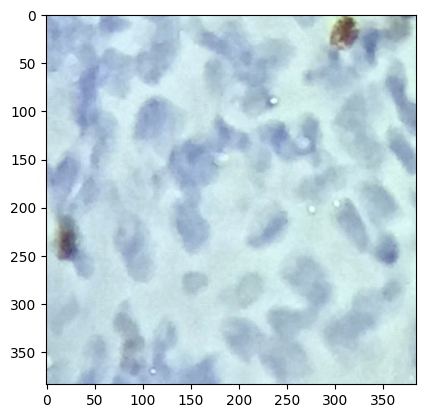

In [87]:
plt.imshow(im)

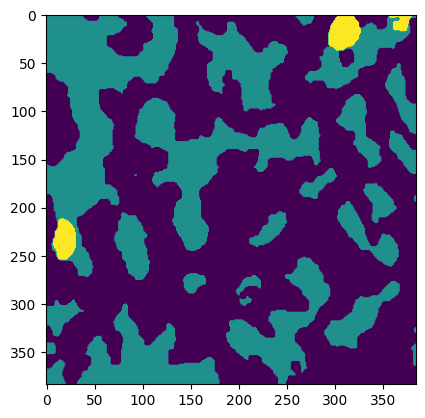

In [88]:
plt.imshow(gt)

In [89]:
preds = model.predict(x)
preds = preds[0,:,:,:] # (batch_size=1, 384,384,3) -> (384,384,3)

1/1 [==============================] - 0s 22ms/step


In [90]:
np.unique(preds)


array([9.2702999e-04, 9.5131173e-04, 9.5769635e-04, ..., 9.9322683e-01,
       9.9328607e-01, 9.9351525e-01], dtype=float32)

In [91]:
def get_segmentation_map(prediction):
    # Step 1: Get the class index
    class_indices = np.argmax(preds, axis=-1)
    print('class_indices',np.unique(class_indices))

    # Step 2: Reshape the index array
    reshaped_indices = class_indices.reshape((class_indices.shape[0], class_indices.shape[1]))
    print('reshaped_indices',np.unique(reshaped_indices))

    # Step 3: Create the segmentation map
    segmentation_map = np.zeros_like(reshaped_indices, dtype=np.uint8)
    for class_label in np.unique(reshaped_indices):
        segmentation_map[reshaped_indices == class_label] = class_label

    print('unique:',np.unique(segmentation_map))

    return segmentation_map

class_indices [0 1 2]
reshaped_indices [0 1 2]
unique: [0 1 2]


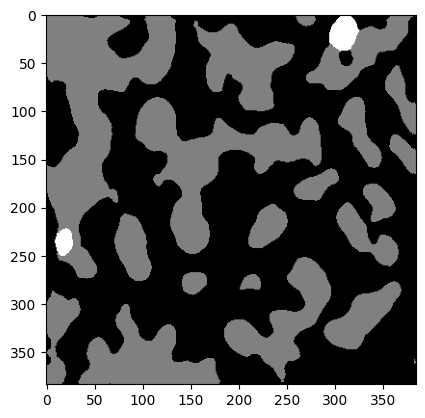

In [92]:
plt.imshow(get_segmentation_map(preds),cmap='gray')

class_indices [0 1 2]
reshaped_indices [0 1 2]
unique: [0 1 2]


Text(0.5, 1.0, 'PREDICTED MASK')

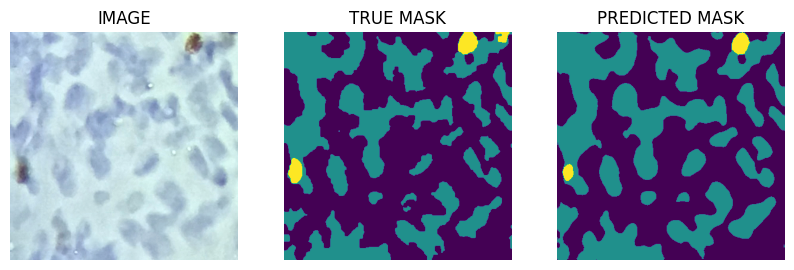

In [93]:
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(im)
plt.axis('off')
plt.title("IMAGE")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(gt)
plt.axis('off')
plt.title("TRUE MASK")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(get_segmentation_map(preds))
plt.axis('off')
plt.title("PREDICTED MASK")



## TF LITE CREATION



In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Watershed Algorithm for Tumour cellularity

In [94]:
#Unique values in image
x = get_segmentation_map(preds)
np.unique(x)

class_indices [0 1 2]
reshaped_indices [0 1 2]
unique: [0 1 2]


array([0, 1, 2], dtype=uint8)

class_indices [0 1 2]
reshaped_indices [0 1 2]
unique: [0 1 2]


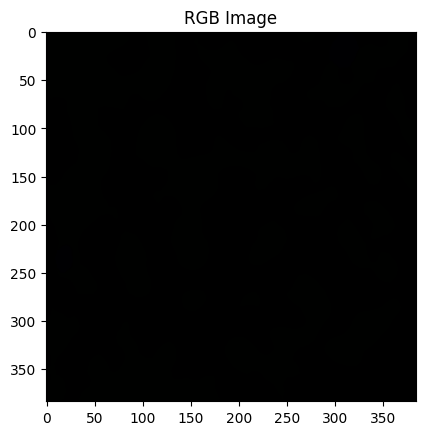

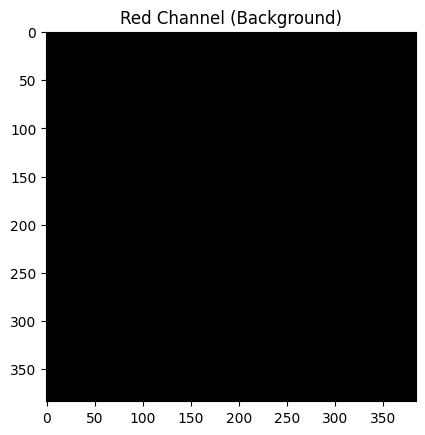

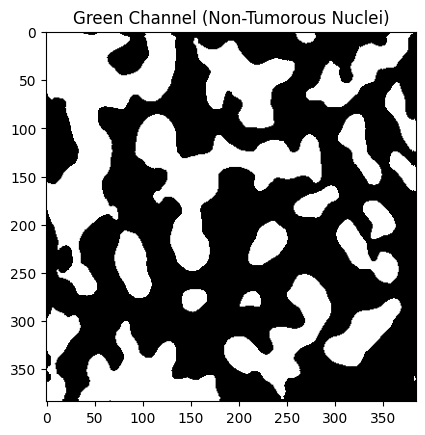

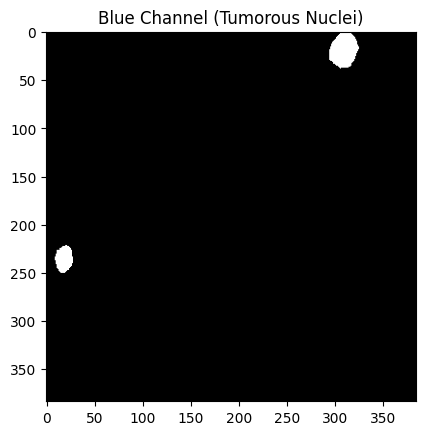

In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_data = get_segmentation_map(preds)

new_image = np.empty((384, 384, 3), dtype=np.uint8)

image_cp = image_data.copy()
image_cp[image_cp == 1] = 0
image_cp[image_cp == 2] = 0
new_image[:, :, 0] = image_cp  # Red channel for  background

image_cp = image_data.copy()
image_cp[image_cp == 0] = 0
image_cp[image_cp == 2] = 0
new_image[:, :, 1] = image_cp  # Green channel for non-tumorous nuclei

image_cp = image_data.copy()
image_cp[image_cp == 0] = 0
image_cp[image_cp == 1] = 0
new_image[:, :, 2] = image_cp  # Blue channel for tumorous nuclei


# Display the RGB image
plt.imshow(new_image)
plt.title("RGB Image")
plt.show()

# Display the R channel (background)
plt.imshow(new_image[:, :, 0], cmap='gray')
plt.title("Red Channel (Background)")
plt.show()

# Display the G channel (non-tumorous nuclei)
plt.imshow(new_image[:, :, 1], cmap='gray')
plt.title("Green Channel (Non-Tumorous Nuclei)")
plt.show()

# Display the B channel (tumorous nuclei)
plt.imshow(new_image[:, :, 2], cmap='gray')
plt.title("Blue Channel (Tumorous Nuclei)")
plt.show()


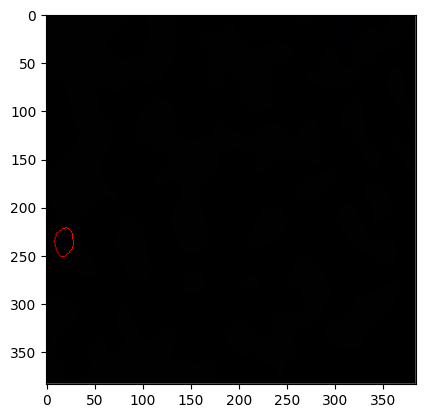

Total tumorous cells: 2


In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the image to grayscale, the image is in the format (height, width, channels), and by selecting [:, :, 2], it takes only the third channel, which is usually the blue channel.
img = new_image[:, :, 2]

# the image img is thresholded to create a binary image (binary_image).
# Thresholding converts the grayscale image into a binary image, where values above the threshold (1 in this case) become 255 (white) and values below the threshold become 0 (black).
ret, binary_image = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

 """
 This line performs a distance transform on the binary image (binary_image).
 A distance transform calculates the distance of each non-zero pixel to the nearest zero (background) pixel.
 This is done using the L2 distance metric (Euclidean distance) and with a distance type of 3.
 """
dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)


"""
The distance map obtained from the previous step (dist_transform) is then thresholded again to create the sure foreground (sure_fg).
Pixels with distances greater than 50% of the maximum distance are set to 0 (black),
and pixels with distances less than or equal to 50% of the maximum distance are set to 255 (white).
"""
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

# Convert the sure foreground to 8-bit unsigned integer (required for cv2.connectedComponentsWithStats)
sure_fg = np.uint8(sure_fg)

# Apply connected component analysis to label connected regions (tumorous cells will have the label 2)
"""
The connected component analysis is performed on the sure_fg image.
It labels the connected regions and returns the output,
which contains the labeled markers and statistics about each connected component.
"""
output = cv2.connectedComponentsWithStats(sure_fg, connectivity=4)

# Retrieve the labeled markers (output[1]) and the total number of nuclei (excluding background label)
"""
The labels variable contains the labeled markers, and num_nuclei stores the total number of nuclei (connected components) excluding the background label.
"""
labels, num_nuclei = output[1], output[0] - 1

# Use the watershed algorithm to segment the nuclei based on markers
"""
This set of lines applies the watershed algorithm to segment the nuclei based on the markers. The connected components obtained from sure_fg are used as markers,
and the watershed algorithm is applied on the original new_image.
Watershed algorithm divides the image into regions based on the markers and intensity gradients, helping to separate individual nuclei.
"""
markers = cv2.connectedComponents(sure_fg, connectivity=4)[1]
markers = markers + 1
markers[markers == 1] = 0
markers = cv2.watershed(new_image, markers)

# Count the number of cells by counting unique markers (excluding background marker with value 0)
"""
The number of cells is determined by counting the unique markers in the segmented markers image, excluding the background marker with a value of 0
"""
num_cells = len(np.unique(markers)) - 1

# Visualize the segmented nuclei with boundary regions marked in red
"""
In this line, the boundary regions of the segmented nuclei are marked in red.
The pixels with a value of -1 in the markers image correspond to the boundary regions, and they are colored red in the new_image.
"""
new_image[markers == -1] = [255, 0, 0]

# Display the image with segmentation and boundary regions
plt.imshow(new_image)
plt.show()

print("Total tumorous cells:", num_cells)


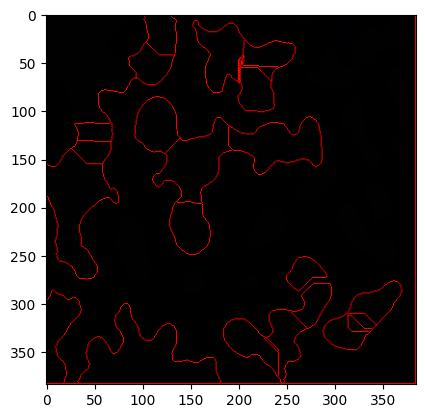

Total non-tumorous cells: 26


In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the image to grayscale
img = new_image[:, :, 1]

# Threshold the grayscale image to obtain a binary image where tumorous cells are white (255) and others are black (0)
ret, binary_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)

# Apply distance transform to create a distance map
dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)

# Convert the distance map to a binary image
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

# Convert the sure foreground to 8-bit unsigned integer (required for cv2.connectedComponentsWithStats)
sure_fg = np.uint8(sure_fg)

# Apply connected component analysis to label connected regions (tumorous cells will have the label 2)
output = cv2.connectedComponentsWithStats(sure_fg, connectivity=4)

# Retrieve the labeled markers (output[1]) and the total number of nuclei (excluding background label)
labels, num_nuclei = output[1], output[0] - 1

# Use the watershed algorithm to segment the nuclei based on markers
markers = cv2.connectedComponents(sure_fg, connectivity=4)[1]
markers = markers + 1
markers[markers == 1] = 0
markers = cv2.watershed(new_image, markers)

# Count the number of cells by counting unique markers (excluding background marker with value 0)
num_cells = len(np.unique(markers)) - 1

# Visualize the segmented nuclei with boundary regions marked in red
new_image[markers == -1] = [255, 0, 0]

# Display the image with segmentation and boundary regions
plt.imshow(new_image)
plt.show()

print("Total non-tumorous cells:", num_cells)